# Ui-Wing Cheah
## EN 625.633 Module 12 Assignment

In [4]:
# imports
import numpy as np 
import scipy.stats as sp 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [5]:
# functons

def int_ito(hfunc,tvec,dwvec,*args,**kwargs):
    # function to run ito integral
    wvec = dwvec.cumsum()
    hval = hfunc(tvec,wvec,*args,**kwargs)
    int_val = hval[:-1]*(wvec[1:]-wvec[:-1])
    return int_val

def int_strato(hfunc,tvec,dwvec,*args,**kwargs):
    # function to run stratonovich integral
    wvec = dwvec.cumsum()
    hval = hfunc(tvec,wvec,*args,**kwargs)
    hval_bar = 0.5*(hval[:-1]+hval[1:])
    int_val = hval_bar*(wvec[1:]-wvec[:-1])
    return int_val

def int_strato_adj(hfunc,tvec,dwvec,dt,*args,**kwargs):
    # function to run stratonovich integral with adjustment
    wvec = dwvec.cumsum()
    hval = hfunc(tvec,wvec,*args,**kwargs)
    hval_bar = 0.5*(hval[:-1]+hval[1:])
    # getting z-vector
    dz = sp.norm(loc=0,scale=pow(dt/4,0.5)).rvs(size=(len(hval_bar),))    
    int_val = (hval_bar+dz)*(wvec[1:]-wvec[:-1])
    return int_val


def brownian_motion(T,N,K=None,sd=1000,*args,**kwargs):
    # create brownian motion path
    np.random.seed(sd)
    # geting time increments
    dt = np.linspace(0,T,N+1)
    # getting all the dWs
    dsig = T/N
    if K is None:
        dW = sp.norm(loc=0,scale=pow(dsig,0.5)).rvs(size=(N,))
        dW = np.concatenate([np.array([0,]),dW])
    else:
        dW = sp.norm(loc=0,scale=pow(dsig,0.5)).rvs(size=(N,K))
        dW = np.concatenate([np.zeros(shape=(1,K)),dW])

    results = pd.DataFrame({'t':pd.Series(dt),'dW':dW,'W':dW.cumsum()})
    return results 

def brownianSimulator(T,N,K=1,*args,**kwargs):
    # implementation of R-code provided by Dr Botts
    # geting time increments
    tdelta = np.linspace(0,T,N+1)
    # getting all the dWs
    dsig = T/N
    dW = sp.norm(loc=0,scale=pow(dsig,0.5)).rvs(size=(N,))
    # Getting the cumulative values
    Wt = np.concatenate(np.array([[0,],dW.cumsum()]))
    ax_ = sns.lineplot(x=tdelta,y=Wt,marker='o',)
    return Wt,ax_


def OrnUhlen_process(theta=1,mu=20,sigma=10,T=1,N=pow(2,8),x0=1,dW=None,*args,**kwargs):
    # initialize the black-scholes values
    EM_soln = np.concatenate([np.array([x0,]),np.zeros(shape=(N,))])
    # geting time increments
    tstep = T/N
    # getting all the dWs
    # Getting the cumulative values of the shocks
    bpath = brownian_motion(T,N)
    Wt = bpath['W'].values
    dW = bpath['dW'].values
    tdelta = bpath['t'].values
    dt = tdelta[1:]-tdelta[:-1]

    # initialize the analytical solution
    soln = np.concatenate([np.array([x0,]),np.zeros(shape=(N,))])
    
    for j,t_ in enumerate(tdelta[1:],):
        # gettiing the analytical solution
        soln_h = lambda s,*args,**kwargs:sigma*np.exp(s-t_)
        soln[j+1] = x0*np.exp(-theta*t_)+mu*(1-np.exp(-theta*t_))+ int_ito(soln_h,tdelta[:j+2],dW[:j+2]).sum()
        
        # getting the empircal solution - EM Algorithm
        f_x = (mu-EM_soln[j])*theta *dt[j]
        g_x = sigma*dW[j+1]
        EM_soln[j+1]=EM_soln[j]+f_x+g_x

    results = pd.DataFrame({'Analytical':pd.Series(data=soln,index=tdelta), 'EM':pd.Series(data=EM_soln,index=tdelta)})
    return results

def BlackScholes_process(T,N,lambda_,mu,sd=1000,*args,**kwargs):
    # initialize the black-scholes values
    x0=1
    EM_soln = np.concatenate([np.array([x0,]),np.zeros(shape=(N,))])
    # geting time increments
    tstep = T/N
    
    # getting all the dWs
    # dsig = T/N
    # dW = np.concatenate([np.array([0,]), sp.norm(loc=0,scale=pow(dsig,0.5)).rvs(size=(N,))])
    # Getting the cumulative values of the shocks
    # Wt =dW.cumsum()
    bpath = brownian_motion(T,N,sd=sd)
    Wt = bpath['W'].values
    dW = bpath['dW'].values
    tdelta = bpath['t'].values
    # start with the analytical solution
    soln = x0*np.exp((lambda_-pow(mu,2)/2)*tdelta+mu*Wt)
    
    for j,dw_ in enumerate(dW[1:],):
        f_x = EM_soln[j]*lambda_*tstep
        g_x = EM_soln[j]*mu*dw_
        EM_soln[j+1]=EM_soln[j]+f_x+g_x

    results = pd.DataFrame({'Analytical':pd.Series(data=soln,index=tdelta), 'EM':pd.Series(data=EM_soln,index=tdelta)})
    return results

def BlackScholes_convergence(T,N,lambda_,mu,nmbSim=1000,*args,**kwargs):
    diffs = np.zeros(shape=(nmbSim))
    for nsim in range(nmbSim):
        blk_scholes = BlackScholes_process(T,N,lambda_,mu,sd=nsim,)
        sim_diff = blk_scholes.iloc[-1]['Analytical']-blk_scholes.iloc[-1]['EM']
        diffs[nsim] = sim_diff
    return diffs.mean()

### Problem 1

In [5]:
# run Ornstein-Uhlenbeck
prob_1 = OrnUhlen_process(x0=20,T=5,sigma=10,N=10000)
# get data into plotting
prob_1_df = prob_1.stack()
prob_1_df.index.names = ('t','estim')
plot_df = pd.DataFrame({'t':prob_1_df.index.get_level_values('t'),'estim':prob_1_df.index.get_level_values('estim'),'O-U Value':prob_1_df.values})

Text(0.5, 1.0, 'Ornstein-Uhlenbek Process')

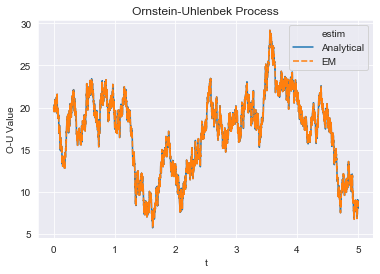

In [6]:
ax_ = sns.lineplot(data=plot_df,x='t',y='O-U Value',hue='estim',style='estim')
ax_.set_title('Ornstein-Uhlenbek Process')

### Problem 2

In [39]:
Nsim = 100
h_test = lambda x,w,*args,**kwargs: pow(w,2)
ito=np.zeros(shape=(Nsim,))
strato=np.zeros(shape=(Nsim,))
strato_adj = np.zeros(shape=(Nsim,))
for ns in range(Nsim):
    bpaths = brownian_motion(100,100,sd=ns)
    ito[ns] = int_ito(h_test,bpaths['t'].values,bpaths['dW'].values).sum()
    strato[ns] = int_strato(h_test,bpaths['t'].values,bpaths['dW'].values).sum()
    strato_adj[ns] = int_strato_adj(h_test,bpaths['t'].values,bpaths['dW'].values,1).sum()


In [40]:
print('Mean from Ito integral: {0:.4f}\nMean from Stratonovich integral: {1:.4f}\nMean from Adjusted Stratonovich integral: {2:.4f}'.format(ito.mean(),strato.mean(),strato_adj.mean()))


Mean from Ito integral: 7.1736
Mean from Stratonovich integral: -46.6618
Mean from Adjusted Stratonovich integral: -45.9246


### Problem 3

In [12]:
Ts = [1,2,3,4,5,10,]
Ns =[100,500,1000,5000]
results = [] 
for t_ in Ts:
    for n_ in Ns:
        results.append((t_,n_*t_,BlackScholes_convergence(t_,n_,lambda_=2,mu=1,)))

sim_results = pd.DataFrame.from_records(results,columns=['T','N','Diff'])


In [14]:
print(sim_results.iloc[:20].to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  T &      N &          Diff \\
\midrule
0  &  1 &    100 &      0.194116 \\
1  &  1 &    500 &      0.020596 \\
2  &  1 &   1000 &      0.001772 \\
3  &  1 &   5000 &     -0.001067 \\
4  &  2 &    200 &      5.865056 \\
5  &  2 &   1000 &      0.705580 \\
6  &  2 &   2000 &      0.175659 \\
7  &  2 &  10000 &      0.005325 \\
8  &  3 &    300 &    101.111419 \\
9  &  3 &   1500 &     12.182811 \\
10 &  3 &   3000 &      3.626415 \\
11 &  3 &  15000 &      0.357733 \\
12 &  4 &    400 &   1358.092127 \\
13 &  4 &   2000 &    160.278418 \\
14 &  4 &   4000 &     50.416744 \\
15 &  4 &  20000 &      6.573339 \\
16 &  5 &    500 &  15721.232184 \\
17 &  5 &   2500 &   1816.500789 \\
18 &  5 &   5000 &    574.524757 \\
19 &  5 &  25000 &     86.536954 \\
\bottomrule
\end{tabular}



In [11]:
sim_results

,T,N,Diff
0,1,100,1.941157e-01
1,1,500,2.059614e-02
2,1,1000,1.772172e-03
3,1,5000,-1.066994e-03
4,5,500,1.572123e+04
5,5,2500,1.816501e+03
6,5,5000,5.745248e+02
7,5,25000,8.653695e+01
8,10,1000,1.079494e+09
9,10,5000,1.216069e+08


### Problem 4

In [10]:
uvar = sp.uniform.rvs(size=(100,))

In [16]:
uvar[uvar>=0.5]=1

In [18]:
uvar[uvar<0.5]=-1

In [19]:
uvar

array([ 1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,
       -1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,
        1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
       -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,
       -1., -1., -1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,
       -1., -1.,  1., -1., -1., -1.,  1., -1., -1.])

In [28]:
def simulation_p4(*args,**kwargs):
    nobs = [100,500,1000,2000,5000,10000,50000,100000]
    ksim = 10
    results = {}
    for n in nobs:
        mvec = np.zeros(shape=(ksim,))
        for k_ in range(ksim):
            #simulate w froma uniform distribution and then applying a switch
            wvar = sp.uniform(loc=0,scale=1).rvs(size=(n,))
            wvar[wvar<=0.5]=-1
            wvar[wvar>0.5]=1
            # getting z from a normal distrobution
            zvar = sp.norm(loc=0,scale=pow(1/n,2)).rvs(size=(n,))
            mvec[k_]=np.abs(wvar.mean()-zvar.mean())
        results[n] = pd.Series(mvec)
    
    results = pd.DataFrame(results)
    return results


In [29]:
# getting simulation results
p4_results = simulation_p4()

In [47]:
print(p4_results.mean().to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
100    &  0.103997 \\
500    &  0.035600 \\
1000   &  0.030200 \\
2000   &  0.031700 \\
5000   &  0.006840 \\
10000  &  0.008480 \\
50000  &  0.003920 \\
100000 &  0.003048 \\
\bottomrule
\end{tabular}



In [31]:
p4_results

,100,500,1000,2000,5000,10000,50000,100000
0,0.119989,0.056,0.048,0.071,0.0120,0.0110,0.00244,0.00386
1,0.039991,0.020,0.022,0.077,0.0056,0.0094,0.00392,0.00316
2,0.219985,0.020,0.010,0.020,0.0024,0.0148,0.00328,0.00088
3,0.260015,0.024,0.028,0.024,0.0056,0.0142,0.00520,0.00760
4,0.079990,0.024,0.010,0.024,0.0052,0.0138,0.00604,0.00354
5,0.020016,0.028,0.044,0.013,0.0044,0.0062,0.00444,0.00064
6,0.079997,0.072,0.034,0.042,0.0004,0.0020,0.00044,0.00580
7,0.099987,0.056,0.032,0.037,0.0140,0.0018,0.00572,0.00130
8,0.080002,0.004,0.056,0.005,0.0052,0.0058,0.00056,0.00238
9,0.039996,0.052,0.018,0.004,0.0136,0.0058,0.00716,0.00132
